<a href="https://colab.research.google.com/github/gyuwonchoi/-CodingTest/blob/main/Vision_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [53]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화

# pass through sequentially 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [63]:
data_dir = 'drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data'

# 'data/hymenoptera_data/train'과 'data/hymenoptera_data/val'을 순서대로 접근함
# ImageFolder 모듈은 data/category/xxx.png 형식인 데이터에 대하여 접근
# 형식 {x: x에 대입되는 식 for x in range} 꼴
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train', 'val']}

# 로드한 데이터에 대하여 DataLoader로 배치 단위로 묶어줌 
# shuffle 이 True 가 되어야함 
# 변형된 데이터로 배치화
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=False, num_workers=4) for x in ['train', 'val']}

# 카테고리 별로, 리스트로 넣음: {'train': 244, 'val': 153}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# ImageFolder returns Dataset object with contains tuples => (image, class).
# approach: image_datasets['train'].imgs // image_datasets['train'].classes
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
print(image_datasets['train'].imgs)

[('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/0013035.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/116570827_e9c126745d.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/1262877379_64fcada201.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg', 0), ('drive/MyDrive/AI_Project/transfer_learning/hymenoptera_data/train/a

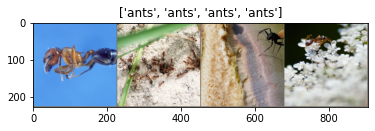

In [64]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # unnormalize 
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [67]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [68]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [69]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [70]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5392 Acc: 0.7049
val Loss: 0.2837 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4691 Acc: 0.7951
val Loss: 0.2224 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.3716 Acc: 0.8525
val Loss: 0.2372 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4442 Acc: 0.8033
val Loss: 0.4050 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.5005 Acc: 0.7705
val Loss: 0.4861 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4582 Acc: 0.8443
val Loss: 0.6006 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.4791 Acc: 0.8156
val Loss: 0.3311 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.3403 Acc: 0.8648
val Loss: 0.3293 Acc: 0.8627

Epoch 8/24
----------
train Loss: 0.3267 Acc: 0.8443
val Loss: 0.3055 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3070 Acc: 0.8689
val Loss: 0.2648 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.3069 Acc: 0.8730
val Loss: 0.2430 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3067 Acc: 0.8689
val Loss: 0.3254 Acc: 0.8758

Ep

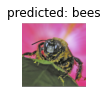

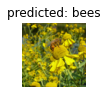

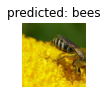

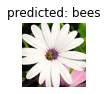

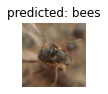

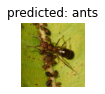

In [71]:
visualize_model(model_ft)

In [72]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [73]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6886 Acc: 0.6352
val Loss: 0.3007 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4584 Acc: 0.7992
val Loss: 0.2949 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4759 Acc: 0.7623
val Loss: 0.2684 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5581 Acc: 0.7623
val Loss: 0.2459 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.3520 Acc: 0.8525
val Loss: 0.2624 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3460 Acc: 0.8361
val Loss: 0.1921 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.4909 Acc: 0.8074
val Loss: 0.2336 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4893 Acc: 0.8238
val Loss: 0.1823 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3587 Acc: 0.8525
val Loss: 0.1854 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3649 Acc: 0.8156
val Loss: 0.1956 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3611 Acc: 0.8320
val Loss: 0.2409 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3092 Acc: 0.8525
val Loss: 0.1850 Acc: 0.9608

Ep

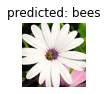

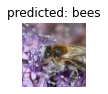

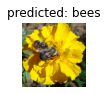

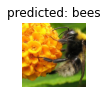

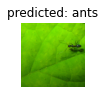

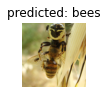

In [74]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()